<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/f-DuasBases/ClassificadorXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais


<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [1]:
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
!pip3 install -U pyFTS
!pip3 install SimpSOM
!pip install dispy
#!pip install matplotlib==3.1.3

     |████████████████████████████████| 175 kB 5.1 MB/s 
     |████████████████████████████████| 11.2 MB 6.4 MB/s 
     |████████████████████████████████| 895 kB 48.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 426 kB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached pycos-4.12.1-py3-none-any.whl
  Created wheel for dispy: filename=dispy-4.15.1-py3-none-any.whl size=213151 sha256=4b2047f53488be663106e938470ecb2f16f8eeffcf81e32bab6ffa780a1a619a
  Stored in directory: /root/.cache/pip/wheels/74/a9/a9/da60ca2929aa2f5df2ee4b19a3b509d5fad720442045da22d1
Successfully built dispy


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

In [3]:
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets = {}

dff = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosFalha.xlsx')
dfn = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosNormais.xlsx')

dados_treino_Falha = dff[0:1200] 
dados_teste_Falha = dff[1200:1800]

dados_treino_Normal = dff[0:1200] 
dados_teste_Normal = dff[1200:1800]

In [4]:
print(dados_treino_Falha)

                    Data  LIT_2012KS_0251_FilteredSignal  \
0    2021-12-05 08:50:13                       35.298019   
1    2021-12-05 08:51:25                       69.698112   
2    2021-12-05 08:52:37                       86.492775   
3    2021-12-05 08:53:49                       87.605766   
4    2021-12-05 08:55:01                       87.592270   
...                  ...                             ...   
1195 2021-12-08 00:43:01                       50.016048   
1196 2021-12-08 00:44:13                       45.235531   
1197 2021-12-08 00:45:25                       40.457817   
1198 2021-12-08 00:46:37                       34.923355   
1199 2021-12-08 00:47:49                       27.762506   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
0                        0.000000                604.000305   
1                        0.000000                594.372681   
2                        0.000000                548.985413   
3                        0.

In [5]:
print(dados_treino_Normal)

                    Data  LIT_2012KS_0251_FilteredSignal  \
0    2021-12-05 08:50:13                       35.298019   
1    2021-12-05 08:51:25                       69.698112   
2    2021-12-05 08:52:37                       86.492775   
3    2021-12-05 08:53:49                       87.605766   
4    2021-12-05 08:55:01                       87.592270   
...                  ...                             ...   
1195 2021-12-08 00:43:01                       50.016048   
1196 2021-12-08 00:44:13                       45.235531   
1197 2021-12-08 00:45:25                       40.457817   
1198 2021-12-08 00:46:37                       34.923355   
1199 2021-12-08 00:47:49                       27.762506   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
0                        0.000000                604.000305   
1                        0.000000                594.372681   
2                        0.000000                548.985413   
3                        0.

In [6]:
print(dados_teste_Falha)

                    Data  LIT_2012KS_0251_FilteredSignal  \
1200 2021-12-08 00:49:01                       21.398041   
1201 2021-12-08 00:50:13                       16.841631   
1202 2021-12-08 00:51:25                       10.937268   
1203 2021-12-08 00:52:37                       12.856474   
1204 2021-12-08 00:53:49                       48.740646   
...                  ...                             ...   
1795 2021-12-08 22:26:13                       21.972658   
1796 2021-12-08 22:27:25                       16.798357   
1797 2021-12-08 22:28:37                        9.433760   
1798 2021-12-08 22:29:49                        5.125467   
1799 2021-12-08 22:31:01                       24.082239   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
1200                    58.653568                730.848328   
1201                    58.494728                717.443176   
1202                    52.552979                749.952576   
1203                    23.

In [7]:
print(dados_teste_Normal)

                    Data  LIT_2012KS_0251_FilteredSignal  \
1200 2021-12-08 00:49:01                       21.398041   
1201 2021-12-08 00:50:13                       16.841631   
1202 2021-12-08 00:51:25                       10.937268   
1203 2021-12-08 00:52:37                       12.856474   
1204 2021-12-08 00:53:49                       48.740646   
...                  ...                             ...   
1795 2021-12-08 22:26:13                       21.972658   
1796 2021-12-08 22:27:25                       16.798357   
1797 2021-12-08 22:28:37                        9.433760   
1798 2021-12-08 22:29:49                        5.125467   
1799 2021-12-08 22:31:01                       24.082239   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
1200                    58.653568                730.848328   
1201                    58.494728                717.443176   
1202                    52.552979                749.952576   
1203                    23.

## Analisando as Séries Temporais

     |████████████████████████████████| 13.1 MB 5.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simpsom 2.0.1 requires matplotlib>=3.3.3, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


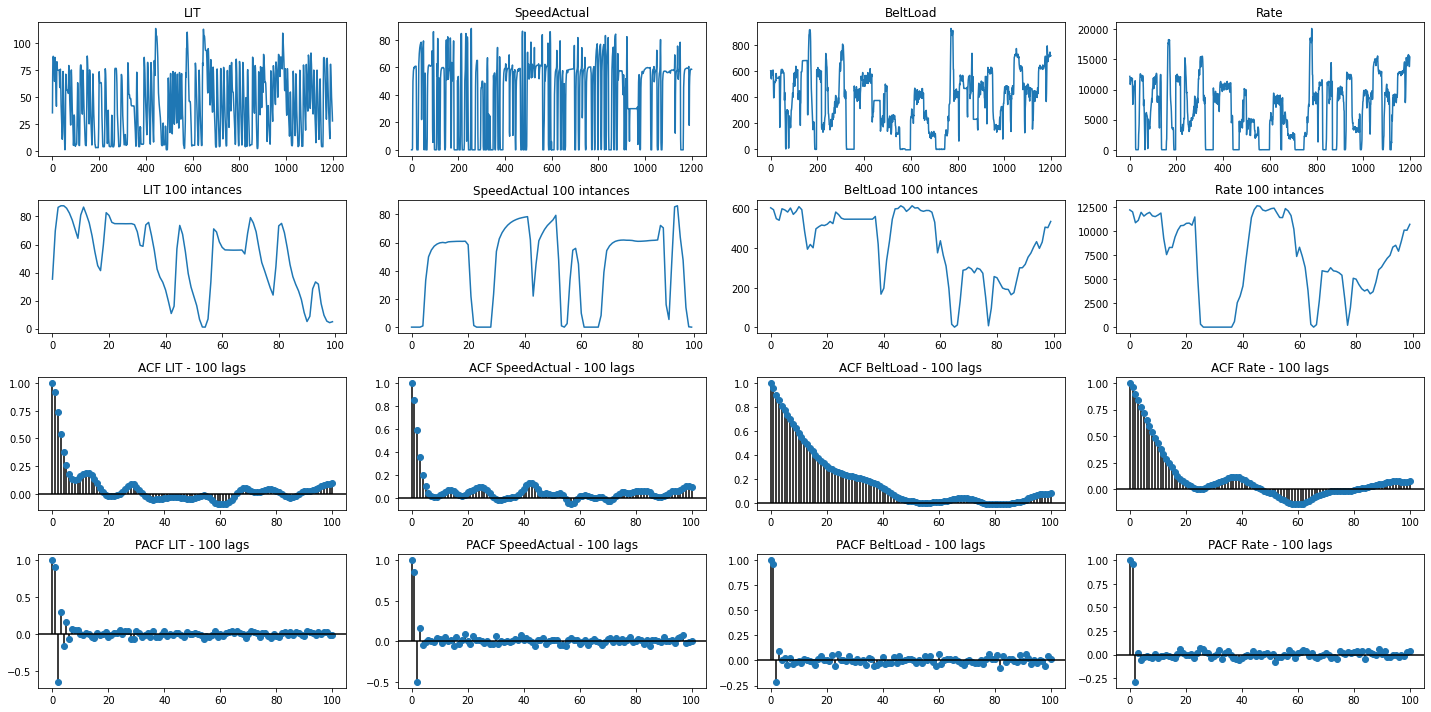

In [8]:
#Dados com Falhas
!pip install matplotlib==3.1.1

from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets1 = {}

datasets1['LIT'] = dados_treino_Falha.get('LIT_2012KS_0251_FilteredSignal')
datasets1['SpeedActual'] = dados_treino_Falha.get('_AL_2012KS_06M1_SpeedActual')
datasets1['BeltLoad'] = dados_treino_Falha.get('WIT_1085KS_2300_BeltLoad')
datasets1['Rate'] = dados_treino_Falha.get('WIT_1085KS_2300_Rate')


fig1, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets1.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

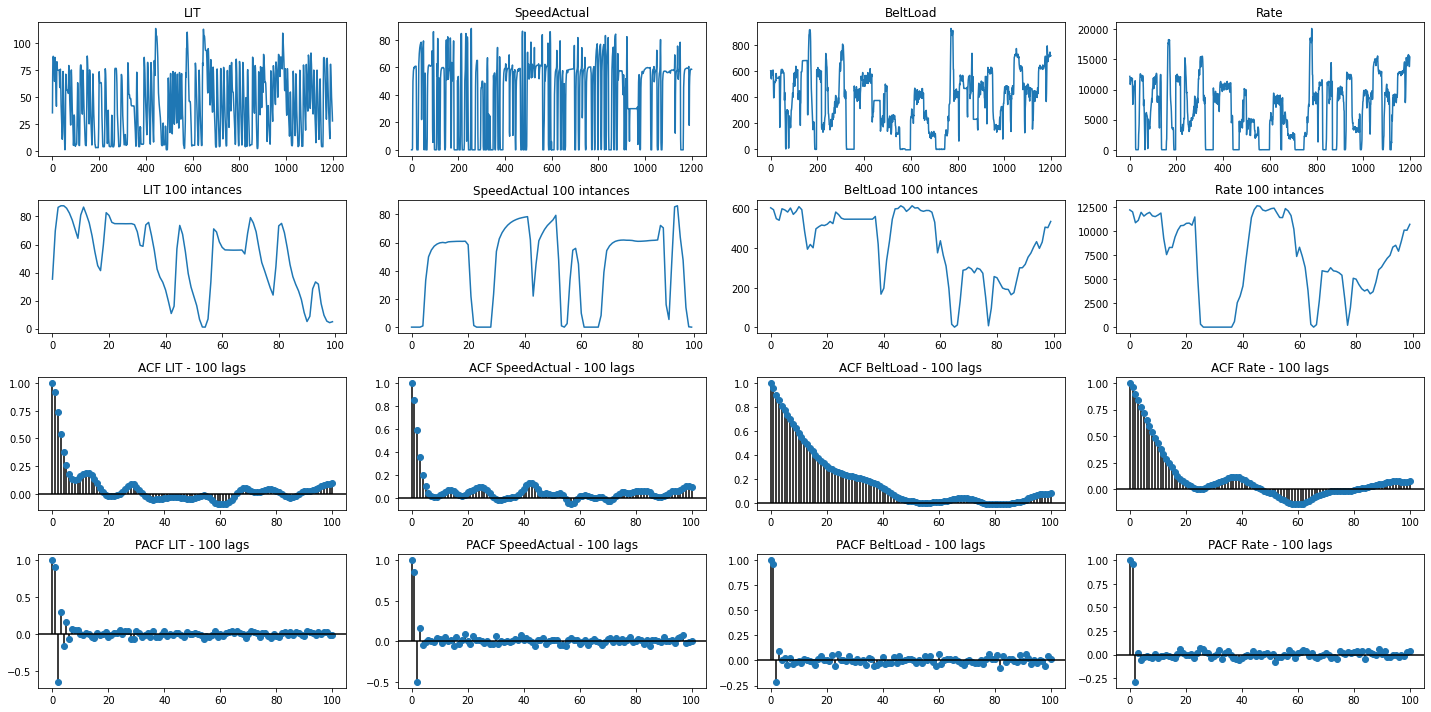

In [9]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets2 = {}

datasets2['LIT'] = dados_treino_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets2['SpeedActual'] = dados_treino_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets2['BeltLoad'] = dados_treino_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets2['Rate'] = dados_treino_Normal.get('WIT_1085KS_2300_Rate')


fig2, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets2.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

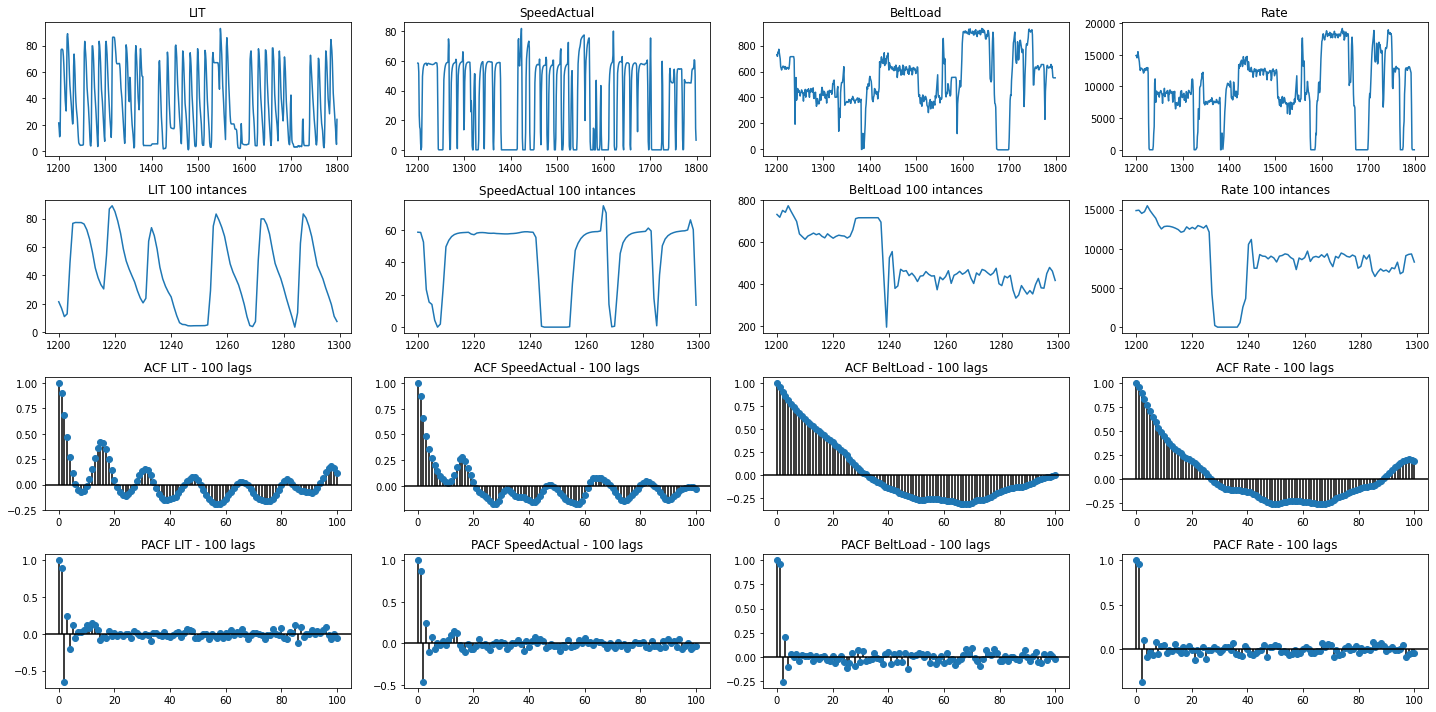

In [10]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets3 = {}

datasets3['LIT'] = dados_teste_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets3['SpeedActual'] = dados_teste_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets3['BeltLoad'] = dados_teste_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets3['Rate'] = dados_teste_Normal.get('WIT_1085KS_2300_Rate')


fig3, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets3.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

IndexError: ignored

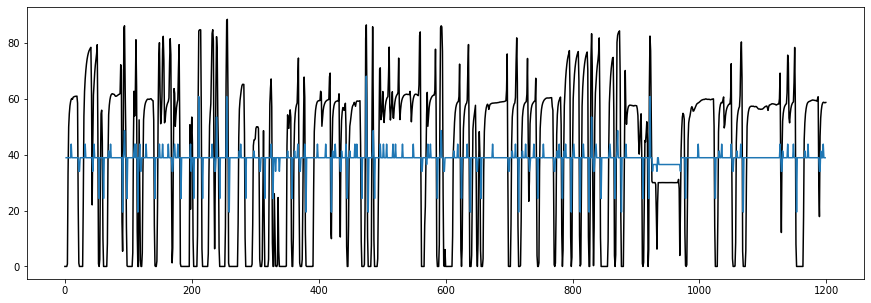

In [22]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner, Entropy.EntropyPartitioner, FCM.FCMPartitioner, CMeans.CMeansPartitioner ]

k = 5

rows = []

y1=np.asarray(datasets1['SpeedActual'])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y1, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part = metodo(data=y1, npart=k)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y1)
  forecasts = model.predict(y1)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=part.name)
  
  rmse, mape, u = Measures.get_point_statistics(y1, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

In [23]:
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets1['LIT']

part = Grid.GridPartitioner(data=np.asarray(y1), npart=k)

for contador, metodo in enumerate(metodos):
  model = metodo(partitioner=part, progress=False, type='distribution')
  if model.is_high_order:
    model = metodo(partitioner=part, order=2)
  model.fit(np.asarray(y1))
  print(model)

Probabilistic FTS:
(0.078) A0,A0 -> (0.583)A0, (0.326)A1, (0.059)A2, (0.026)A3, (0.006)A4, (0.001)A5
(0.044) A0,A1 -> (0.376)A0, (0.285)A1, (0.115)A2, (0.068)A3, (0.081)A4, (0.07)A5, (0.005)A6
(0.007) A0,A2 -> (0.002)A0, (0.033)A1, (0.132)A2, (0.207)A3, (0.152)A4, (0.291)A5, (0.172)A6, (0.011)A7
(0.003) A0,A3 -> (0.01)A2, (0.032)A3, (0.165)A4, (0.151)A5, (0.565)A6, (0.077)A7
(0.001) A0,A4 -> (0.001)A3, (0.013)A4, (0.027)A5, (0.531)A6, (0.428)A7
(0.0) A0,A5 -> (0.053)A5, (0.54)A6, (0.406)A7
(0.052) A1,A0 -> (0.586)A0, (0.342)A1, (0.049)A2, (0.017)A3, (0.006)A4, (0.001)A5
(0.057) A1,A1 -> (0.402)A0, (0.342)A1, (0.082)A2, (0.065)A3, (0.07)A4, (0.038)A5, (0.002)A6
(0.013) A1,A2 -> (0.024)A0, (0.142)A1, (0.158)A2, (0.224)A3, (0.161)A4, (0.184)A5, (0.1)A6, (0.007)A7
(0.008) A1,A3 -> (0.0)A1, (0.011)A2, (0.074)A3, (0.209)A4, (0.271)A5, (0.373)A6, (0.061)A7
(0.008) A1,A4 -> (0.007)A3, (0.004)A4, (0.111)A5, (0.669)A6, (0.209)A7
(0.005) A1,A5 -> (0.029)A5, (0.591)A6, (0.38)A7
(0.0) A1,A6 -> (0.3

In [26]:
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets1['SpeedActual']

part = Grid.GridPartitioner(data=np.asarray(y2), npart=k)

for contador, metodo in enumerate(metodos):
  model = metodo(partitioner=part, progress=False, type='distribution')
  if model.is_high_order:
    model = metodo(partitioner=part, order=2)
  model.fit(np.asarray(y2))
  print(model)



Probabilistic FTS:
(0.187) A0,A0 -> (0.781)A0, (0.076)A1, (0.057)A2, (0.043)A3, (0.026)A4, (0.012)A5, (0.005)A6, (0.001)A7
(0.017) A0,A1 -> (0.03)A0, (0.003)A1, (0.067)A2, (0.155)A3, (0.388)A4, (0.193)A5, (0.127)A6, (0.036)A7
(0.012) A0,A2 -> (0.013)A0, (0.033)A1, (0.037)A2, (0.023)A3, (0.189)A4, (0.525)A5, (0.096)A6, (0.024)A7, (0.036)A8, (0.023)A9
(0.008) A0,A3 -> (0.021)A0, (0.074)A1, (0.021)A2, (0.011)A3, (0.032)A4, (0.517)A5, (0.225)A6, (0.039)A7, (0.056)A8, (0.004)A9
(0.005) A0,A4 -> (0.004)A4, (0.391)A5, (0.405)A6, (0.068)A7, (0.099)A8, (0.034)A9
(0.003) A0,A5 -> (0.276)A2, (0.182)A3, (0.078)A5, (0.23)A6, (0.072)A7, (0.043)A8, (0.119)A9
(0.001) A0,A6 -> (0.258)A2, (0.304)A3, (0.134)A8, (0.303)A9
(0.0) A0,A7 -> (0.524)A8, (0.476)A9
(0.022) A1,A0 -> (0.914)A0, (0.077)A1, (0.001)A2, (0.001)A3, (0.002)A4, (0.005)A5, (0.0)A6, (0.0)A7
(0.001) A1,A1 -> (0.091)A0, (0.001)A1, (0.026)A2, (0.014)A3, (0.522)A4, (0.341)A5, (0.005)A6, (0.0)A7
(0.002) A1,A2 -> (0.007)A0, (0.009)A1, (0.0)A2, (0

In [16]:
_, _, lhs, rhs = pwfts.ProbabilisticWeightedFTS.flrg_rhs_conditional_probability

SyntaxError: ignored

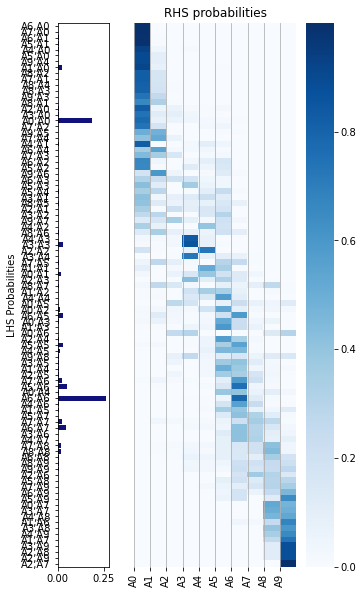

In [25]:
pwfts.visualize_distributions(model)

In [ ]:
dataset = pd.read_excel('../content/sample_data/Base.xlsx')
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

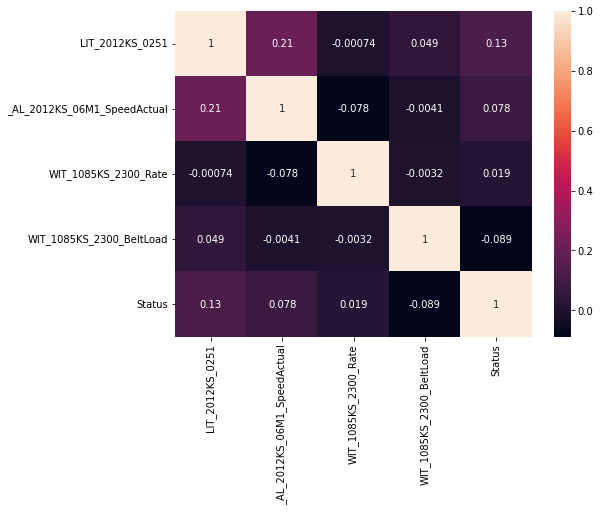

In [ ]:
import seaborn as sns
dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dataset2.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
print(dataset2)

      LIT_2012KS_0251  ...  Status
0           25.444870  ...       1
1           24.390213  ...       1
2           22.518898  ...       1
3           30.281023  ...       1
4           48.265495  ...       1
...               ...  ...     ...
6313         2.114453  ...       0
6314         2.566652  ...       0
6315         3.876476  ...       0
6316         3.395008  ...       0
6317         3.202985  ...       0

[6318 rows x 5 columns]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [ ]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

XGBClassifier()

Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(y_test, ypred)
print(cm)

[[281 197]
 [ 65 721]]


Precisão

In [ ]:
accuracy_score(y_test, ypred)

0.7927215189873418

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 10)

print(accuracies.mean()*100)
print(accuracies.std()*100)

79.20349861073063
1.6023111356796393
